In [1]:
import ast
import networkx as nx
import numpy as np
import openpyxl
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import json

In [ ]:
def create_heterograph(file_path):
    try:
        
        if os.path.basename(file_path) == '.gitkeep':
            print("Skipping .gitkeep file.")
            return None
        
        df = pd.read_excel(file_path, sheet_name='input_data', header=None)
        df = df.dropna(how='all').dropna(axis=1, how='all')

        params_dict = {}
        for _, row in df.iterrows():
            param, value = row[0], row[1]
            if pd.notna(param) and pd.notna(value):
                try:
                    params_dict[param] = float(value)
                except ValueError:
                    params_dict[param] = value

        G = nx.MultiDiGraph()  # Use MultiDiGraph for heterogeneous graph

        # Load edge dictionaries from the JSON file
        with open('./data/DoubleVGraphTemp.json', 'r') as f:
            graph_dict = json.load(f)

        node_types = graph_dict['node_types']
        node_features = graph_dict['node_features']

        # Add nodes with their types and features
        ##TODO add a check when there are no features
        for node_type, nodes in node_types.items():
            for node in nodes:
                features = []
                for feature in node_features[node_type]:
                    if node.startswith('v1'):
                        key = f"{feature}1"
                        value = params_dict.get(key, 0)
                    elif node.startswith('v2'):
                        key = f"{feature}2"
                        value = params_dict.get(key, 0)
                    elif '0' in feature:
                        value = 0
                    else:
                        value = params_dict.get(feature, 0)
                    features.append(value)
                    
                G.add_node(node, type=node_type, features=features)
        
        def convert_str_to_tuple(d):
            converted_dict = {}
            for k, v in d.items():
                # Remove the parentheses and split by comma
                k = k.strip('()').replace("'", "").split(',')
                # Create tuple from the two elements
                tuple_key = (k[0].strip(), k[1].strip())
                converted_dict[tuple_key] = v
            return converted_dict

        # Convert the edge dictionaries
        edge_d1 = convert_str_to_tuple(graph_dict['edge_d1'])
        edge_d2 = convert_str_to_tuple(graph_dict['edge_d2'])
        edge_d1_calc_airgap = convert_str_to_tuple(graph_dict['edge_d1_calc_airgap'])
        edge_d1_calc_ss = convert_str_to_tuple(graph_dict['edge_d1_calc_ss'])
            
        for edge, desc in edge_d1.items():
            features = []
            edge_type='d1'
            for feature in desc:
                value = params_dict.get(feature, 0)
                features.append(value)
            G.add_edge(edge[0], edge[1], type=edge_type, features=features)    
            
        for edge, desc in edge_d2.items():
            features = []
            edge_type='d2'
            for feature in desc:
                value = params_dict.get(feature, 0)
                features.append(value)
            G.add_edge(edge[0], edge[1], type=edge_type, features=features)   

        for edge, desc in edge_d1_calc_airgap.items():
            features = []
            edge_type='d1'
            value = params_dict.get('r_i', 0)-params_dict.get('airgap', 0)
            features.append(value)
            G.add_edge(edge[0], edge[1], type=edge_type, features=features)
            
        for edge, desc in edge_d1_calc_ss.items():
            features = []
            edge_type='d1'
            value = params_dict.get('r_a', 0)-(params_dict.get('r_i', 0)+params_dict.get('h_n', 0)+params_dict.get('h_zk', 0))
            features.append(value)
            G.add_edge(edge[0], edge[1], type=edge_type, features=features)

        metapaths = {path: data["nodes"] for path, data in graph_dict['metapaths'].items()}

        # Store in graph metadata
        G.graph['metapaths'] = metapaths
        
        # Read labels from 'Mgrenz' sheet
        wb = openpyxl.load_workbook(file_path)
        sheet_mgrenz = wb['Mgrenz']
        mgrenz_values = [cell.value for cell in sheet_mgrenz[1] if cell.value is not None]
        
        # sheet = wb['ETA']
        # data = [[cell.value if cell.value is not None else np.nan for cell in row] for row in sheet.iter_rows()]
        # eta_values = np.array(data, dtype=float)

        G.graph['mgrenz_values'] = mgrenz_values 
        # G.graph['eta_values'] = eta_values 
        
        return G
    
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {str(e)}")
        return None

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_motor_networkx(G, figsize=(6, 6)):
    """
    Visualize the motor graph created using NetworkX.
    
    Parameters:
    -----------
    G : nx.MultiDiGraph
        The NetworkX graph created by create_heterograph function
    figsize : tuple
        Figure size for the plot
    """
    plt.figure(figsize=figsize)
    
    # Define color schemes
    node_colors = {
        'v': '#ff7f0e',  # orange for v nodes
        'r': '#1f77b4',  # blue for r nodes
        's': '#2ca02c'   # green for s nodes
    }
    
    edge_colors = {
        'd1': 'red',
        'd2': 'blue'
    }
    
    # Create position layout
    pos = nx.spring_layout(G, k=2.0, iterations=50)
    
    # Prepare node colors and labels
    node_color_list = []
    node_labels = {}
    
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        base_type = node_type[0] if node_type else 'v'  # default to 'v' if no type
        node_color_list.append(node_colors.get(base_type, 'gray'))
        
        # Create node label with features
        features = G.nodes[node].get('features', [])
        if features:
            feature_str = '\n'.join([f"{i}: {v:.2f}" for i, v in enumerate(features)])
            node_labels[node] = f"{node}\n{feature_str}"
        else:
            node_labels[node] = node
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_color_list,
                          node_size=1000)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, 
                           labels=node_labels,
                           font_size=8)
    
    # Draw edges with different colors based on type
    edge_colors_used = set()
    for (u, v, data) in G.edges(data=True):
        edge_type = data.get('type', 'd1')  # default to 'd1' if no type
        color = edge_colors.get(edge_type, 'gray')
        edge_colors_used.add((edge_type, color))
        
        # Draw the edge
        nx.draw_networkx_edges(G, pos,
                             edgelist=[(u, v)],
                             edge_color=color,
                             arrows=True,
                             arrowsize=20)
        
        # Prepare edge label with features
        features = data.get('features', [])
        if features:
            edge_labels = {(u, v): f"{edge_type}\n{features}"}
            nx.draw_networkx_edge_labels(G, pos,
                                       edge_labels=edge_labels,
                                       font_size=8)
    
    # Create legend
    node_legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                     markerfacecolor=color, label=f"{node_type}-type",
                                     markersize=10)
                          for node_type, color in node_colors.items()]
    
    edge_legend_elements = [plt.Line2D([0], [0], color=color, label=f"{edge_type}-type")
                          for edge_type, color in edge_colors.items()]
    
    plt.legend(handles=node_legend_elements + edge_legend_elements,
              loc='center left',
              bbox_to_anchor=(1, 0.5))
    
    plt.title("Motor Graph Structure")
    plt.axis('off')
    plt.tight_layout()
    
    return plt.gcf()

In [4]:
# directory_path = '/home/k64889/Masters-Thesis/data/Testing/raw/'
# graphs = []

# for filename in os.listdir(directory_path):
#     if filename.endswith('.xlsx'):
#         file_path = os.path.join(directory_path, filename)
#         G = create_heterograph(file_path)
#         if G is not None:
#             graphs.append(G)

In [ ]:
import os
from tqdm import tqdm  # For progress bar

def load_motor_graphs(directory_path):
    graphs = []
    excel_files = [f for f in os.listdir(directory_path) if f.endswith('.xlsx')]
    
    print(f"Found {len(excel_files)} Excel files")
    
    # Use tqdm for progress bar
    for filename in tqdm(excel_files, desc="Loading graphs"):
        try:
            file_path = os.path.join(directory_path, filename)
            G = create_heterograph(file_path)
            if G is not None:
                # Verify graph structure
                has_features = all('features' in G.nodes[n] for n in G.nodes())
                has_edge_data = all('type' in G[u][v][0] and 'features' in G[u][v][0] 
                                  for u, v in G.edges())
                
                if has_features and has_edge_data:
                    graphs.append(G)
                else:
                    print(f"Skipping {filename}: Missing required attributes")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    print(f"Successfully loaded {len(graphs)} graphs")
    
    # Basic validation of first graph
    if graphs:
        G = graphs[0]
        print("\nFirst graph info:")
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Node types: {set(nx.get_node_attributes(G, 'type').values())}")
        print(f"Edge types: {set(d['type'] for _, _, d in G.edges(data=True))}")
        print(f"Metapaths: {list(G.graph['metapaths'].keys())}")
        print(f"Target shape: {len(G.graph['mgrenz_values'])}")
    
    return graphs

# Load the graphs
directory_path = '/home/k64889/Masters-Thesis/data/Testing/raw/'
graphs = load_motor_graphs(directory_path)

Found 25 Excel files


Loading graphs:   0%|          | 0/25 [00:00<?, ?it/s]

Loading graphs: 100%|██████████| 25/25 [06:49<00:00, 16.37s/it]

Successfully loaded 25 graphs

First graph info:
Number of nodes: 6
Number of edges: 6
Node types: {'r', 's', 'v'}
Edge types: {'d1', 'd2'}
Metapaths: ['path1', 'path2', 'path3']
Target shape: 191


In [5]:
for graph in graphs:
    print("\nGraph node types:")
    for node, attr in graph.nodes(data=True):
        print(f"Node {node}: type = {attr['type']}")
    break  # Just print first graph


Graph node types:
Node v1: type = v
Node v2: type = v
Node rr: type = r
Node ra: type = r
Node o: type = r
Node s: type = s


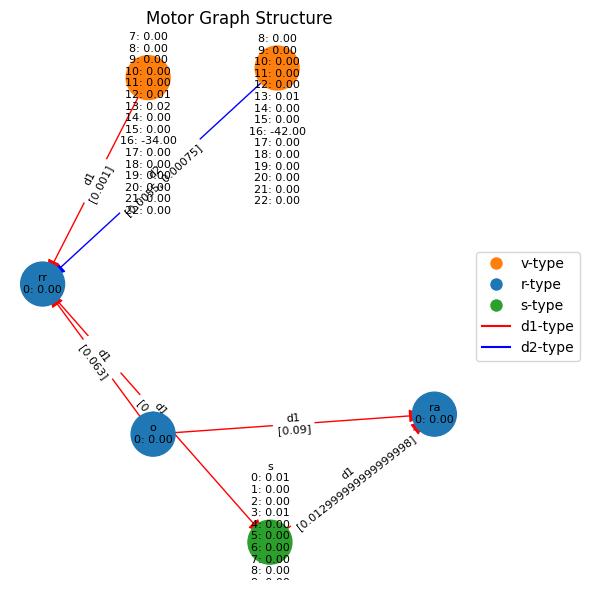

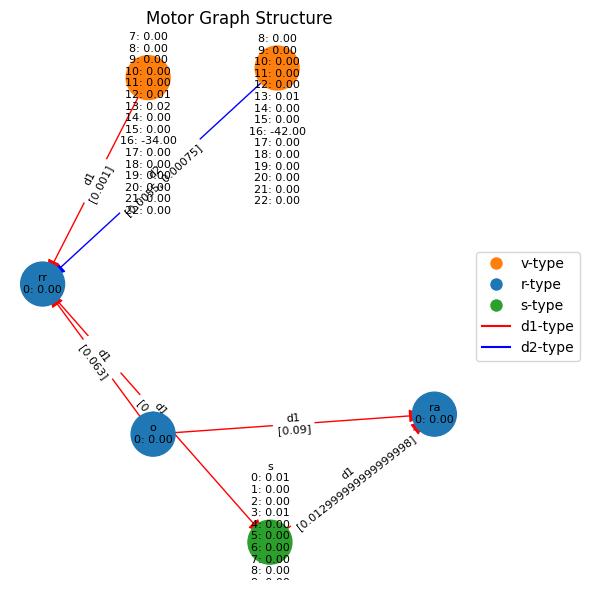

In [6]:
visualize_motor_networkx(graphs[0])

In [11]:
import torch
from torch_geometric.data import HeteroData, Dataset
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, NNConv
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx

class MotorGraphDataset(Dataset):
    def __init__(self, graphs):
        super().__init__()
        self.graphs = graphs
        self.metapaths = graphs[0].graph['metapaths']
        
        # print("\nFirst graph structure:")
        G = graphs[0]
        # for node, attr in G.nodes(data=True):
        #     print(f"Node {node}: type={attr['type']}, features={len(attr['features'])}")
    
    def len(self):
        return len(self.graphs)
    
    def get(self, idx):
        G = self.graphs[idx]
        data = HeteroData()
        
        data.metapaths_dict = G.graph['metapaths']
        
        # Group nodes by their base types
        v_nodes = []
        v_features = []
        r_nodes = []
        r_features = []
        s_nodes = []
        s_features = []
        
        # Collect nodes and features
        for node, attr in G.nodes(data=True):
            if attr['type'] == 'v':
                v_nodes.append(node)
                v_features.append(attr['features'])
            elif attr['type'] == 'r':
                r_nodes.append(node)
                r_features.append(attr['features'])
            elif attr['type'] == 's':
                s_nodes.append(node)
                s_features.append(attr['features'])
        
        # print(f"\nCollected features for graph {idx}:")
        # print(f"v_features: {len(v_features)} nodes with {len(v_features[0]) if v_features else 0} features each")
        # print(f"r_features: {len(r_features)} nodes with {len(r_features[0]) if r_features else 0} features each")
        # print(f"s_features: {len(s_features)} nodes with {len(s_features[0]) if s_features else 0} features each")
        
        # Add node features to data object - correct way
        if v_features:
            data['v'].x = torch.tensor(v_features, dtype=torch.float)
        if r_features:
            data['r'].x = torch.tensor(r_features, dtype=torch.float)
        if s_features:
            data['s'].x = torch.tensor(s_features, dtype=torch.float)
        
        # Add edges
        for u, v, edge_data in G.edges(data=True):
            src_type = G.nodes[u]['type']
            dst_type = G.nodes[v]['type']
            edge_type = edge_data['type']
            edge_name = f"{edge_type}_{src_type}_{dst_type}"
            
            # Get source and target indices
            if src_type == 'v':
                src_idx = v_nodes.index(u)
            elif src_type == 'r':
                src_idx = r_nodes.index(u)
            else:
                src_idx = s_nodes.index(u)
                
            if dst_type == 'v':
                dst_idx = v_nodes.index(v)
            elif dst_type == 'r':
                dst_idx = r_nodes.index(v)
            else:
                dst_idx = s_nodes.index(v)
            
            edge_index = torch.tensor([[src_idx], [dst_idx]], dtype=torch.long)
            edge_attr = torch.tensor([edge_data['features']], dtype=torch.float)
            
            data[(src_type, edge_name, dst_type)].edge_index = edge_index
            data[(src_type, edge_name, dst_type)].edge_attr = edge_attr
        
        # Add target values
        data.y = torch.tensor(G.graph['mgrenz_values'], dtype=torch.float).view(1, -1)  
        
        # Debug print final data structure
        # print("\nFinal data structure:")
        # print("Node stores:", [key for key in data.node_stores])
        # print("Edge stores:", [key for key in data.edge_stores])
        
        return data

In [12]:
dataset = MotorGraphDataset(graphs)

In [13]:
dataset[4]

HeteroData(
  metapaths_dict={
    path1=[4],
    path2=[3],
    path3=[3],
  },
  y=[1, 191],
  v={ x=[2, 23] },
  r={ x=[3, 1] },
  s={ x=[1, 13] },
  (v, d2_v_r, r)={
    edge_index=[2, 1],
    edge_attr=[1, 2],
  },
  (v, d1_v_r, r)={
    edge_index=[2, 1],
    edge_attr=[1, 1],
  },
  (r, d1_r_s, s)={
    edge_index=[2, 1],
    edge_attr=[1, 1],
  },
  (r, d1_r_r, r)={
    edge_index=[2, 1],
    edge_attr=[1, 1],
  },
  (s, d1_s_r, r)={
    edge_index=[2, 1],
    edge_attr=[1, 1],
  }
)

In [14]:
dataset[4].metapaths_dict

{'path1': ['v', 'r', 's', 'r'],
 'path2': ['r', 'v', 'r'],
 'path3': ['r', 's', 'r']}

In [15]:
class MetapathGNN(torch.nn.Module):
    def __init__(self, data, hidden_channels=64):
        super().__init__()
        
        print("\nInitializing MetapathGNN")
        print("Available node types:", [store._key for store in data.node_stores])
        
        self.hidden_channels = hidden_channels
        self.metapaths = data.metapaths_dict
        
        # Node type mapping
        self.node_type_mapping = {
            'v1': 'v', 'v2': 'v',
            'rr': 'r', 'ra': 'r', 'o': 'r',
            's': 's'
        }
        
        # Create input encoders
        self.node_encoders = torch.nn.ModuleDict()
        for node_type in ['v', 'r', 's']:
            if node_type in [store._key for store in data.node_stores]:
                num_features = data[node_type].x.size(1)
                print(f"Creating encoder for {node_type} with {num_features} features")
                self.node_encoders[node_type] = torch.nn.Linear(num_features, hidden_channels)
            else:
                print(f"Warning: No features found for node type {node_type}")
        
        # Create path-specific encoders
        self.path_encoders = torch.nn.ModuleDict()
        for path_name, path_nodes in self.metapaths.items():
            path_layers = []
            for i in range(len(path_nodes) - 1):
                src_node = path_nodes[i]
                dst_node = path_nodes[i + 1]
                src_type = self.node_type_mapping[src_node]
                dst_type = self.node_type_mapping[dst_node]
                edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
                edge_name = f"{edge_type}_{src_type}_{dst_type}"
                
                conv = HeteroConv({
                    (src_type, edge_name, dst_type): NNConv(
                        (hidden_channels, hidden_channels),
                        hidden_channels,
                        torch.nn.Linear(1, hidden_channels * hidden_channels),
                        aggr='mean'
                    )
                })
                path_layers.append(conv)
            self.path_encoders[path_name] = torch.nn.ModuleList(path_layers)
        
        # Batch normalization
        self.batch_norms = torch.nn.ModuleDict({
            node_type: torch.nn.BatchNorm1d(hidden_channels)
            for node_type in ['v', 'r', 's']
        })
        
        # Path attention
        self.path_attention = torch.nn.Linear(hidden_channels, 1)
        
        # Output layers
        self.output = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels * len(self.metapaths), 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, len(data.y))
        )

    def process_metapath(self, x_dict, edge_index_dict, edge_attr_dict, path_name):
        path_nodes = self.metapaths[path_name]
        print(f"\nProcessing metapath {path_name}: {path_nodes}")
        current_x_dict = {k: v.clone() for k, v in x_dict.items()}
        
        for i, layer in enumerate(self.path_encoders[path_name]):
            src_node = path_nodes[i]
            dst_node = path_nodes[i + 1]
            src_type = self.node_type_mapping[src_node]
            dst_type = self.node_type_mapping[dst_node]
            edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
            edge_name = f"{edge_type}_{src_type}_{dst_type}"
            
            print(f"Step {i}: {src_type}->{dst_type} via {edge_name}")
            print(f"Current features: {[k for k in current_x_dict.keys()]}")
            
            if src_type not in current_x_dict or dst_type not in current_x_dict:
                print(f"Missing node features for {src_type} or {dst_type}")
                continue
                
            if (src_type, edge_name, dst_type) in edge_index_dict:
                edge_index = edge_index_dict[(src_type, edge_name, dst_type)]
                edge_attr = edge_attr_dict[(src_type, edge_name, dst_type)]
                
                print(f"Edge index shape: {edge_index.shape}")
                print(f"Edge attr shape: {edge_attr.shape}")
                print(f"Source features shape: {current_x_dict[src_type].shape}")
                print(f"Target features shape: {current_x_dict[dst_type].shape}")
                
                step_dict = {
                    (src_type, edge_name, dst_type): (
                        current_x_dict[src_type],
                        current_x_dict[dst_type],
                        edge_index,
                        edge_attr
                    )
                }
                
                try:
                    current_x_dict = layer(current_x_dict, step_dict)
                    # Apply batch norm and activation for all updated node types
                    for node_type in current_x_dict:
                        if node_type in self.batch_norms:
                            current_x_dict[node_type] = self.batch_norms[node_type](
                                F.relu(current_x_dict[node_type])
                            )
                except Exception as e:
                    print(f"Error in message passing: {str(e)}")
                    continue
            else:
                print(f"Edge type not found: {(src_type, edge_name, dst_type)}")
                print(f"Available edge types: {list(edge_index_dict.keys())}")
        
        return current_x_dict

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        print("\nForward pass:")
        print("Input node types:", list(x_dict.keys()))
        print("Available edge types:", list(edge_index_dict.keys()))
        
        # Initial node encoding
        x_encoded = {}
        for node_type, x in x_dict.items():
            if node_type in self.node_encoders:
                x_encoded[node_type] = self.node_encoders[node_type](x)
                print(f"Encoded {node_type} features: {x_encoded[node_type].shape}")
            else:
                print(f"Warning: No encoder for {node_type}, using original features")
                x_encoded[node_type] = x
        
        # Process each metapath
        path_embeddings = []
        for path_name in self.metapaths:
            try:
                path_x_dict = self.process_metapath(x_encoded, edge_index_dict, edge_attr_dict, path_name)
                final_node = self.metapaths[path_name][-1]
                final_type = self.node_type_mapping[final_node]
                
                if final_type in path_x_dict:
                    path_emb = path_x_dict[final_type]
                    attention_weights = F.softmax(self.path_attention(path_emb), dim=0)
                    path_embedding = torch.sum(path_emb * attention_weights, dim=0)
                    path_embeddings.append(path_embedding)
                    print(f"Successfully processed path {path_name}")
                else:
                    print(f"Missing final type {final_type} for path {path_name}")
            except Exception as e:
                print(f"Error processing path {path_name}: {str(e)}")
                continue
        
        if not path_embeddings:
            print("WARNING: No valid path embeddings generated")
            # Return zero tensor instead of raising error
            return torch.zeros(len(self.metapaths), device=x_dict[list(x_dict.keys())[0]].device)
        
        combined_embedding = torch.cat(path_embeddings)
        return self.output(combined_embedding)

In [16]:
class MetapathGNN(torch.nn.Module):
    def __init__(self, data, hidden_channels=64):
        super().__init__()
        
        print("\nInitializing MetapathGNN")
        print("Available node types:", [store._key for store in data.node_stores])
        
        self.target_size = 191
        self.hidden_channels = hidden_channels
        self.metapaths = data.metapaths_dict
        
        # Node type mapping
        self.node_type_mapping = {
            'v1': 'v', 'v2': 'v',
            'rr': 'r', 'ra': 'r', 'o': 'r',
            's': 's'
        }
        
        # Node encoders
        self.node_encoders = torch.nn.ModuleDict()
        for node_type in ['v', 'r', 's']:
            if node_type in [store._key for store in data.node_stores]:
                num_features = data[node_type].x.size(1)
                print(f"Creating encoder for {node_type} with {num_features} features")
                self.node_encoders[node_type] = torch.nn.Linear(num_features, hidden_channels)
        
        # Path encoders
        self.path_encoders = torch.nn.ModuleDict()
        for path_name, path_nodes in self.metapaths.items():
            path_layers = []
            for i in range(len(path_nodes) - 1):
                src_node = path_nodes[i]
                dst_node = path_nodes[i + 1]
                src_type = self.node_type_mapping[src_node]
                dst_type = self.node_type_mapping[dst_node]
                edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
                edge_name = f"{edge_type}_{src_type}_{dst_type}"
                
                conv = HeteroConv({
                    (src_type, edge_name, dst_type): NNConv(
                        (hidden_channels, hidden_channels),
                        hidden_channels,
                        torch.nn.Linear(1, hidden_channels * 2),
                        aggr='mean'
                    )
                })
                path_layers.append(conv)
            self.path_encoders[path_name] = torch.nn.ModuleList(path_layers)
        
        # Batch normalization
        self.batch_norms = torch.nn.ModuleDict({
            node_type: torch.nn.BatchNorm1d(hidden_channels)
            for node_type in ['v', 'r', 's']
        })
        
        # Output layers
        input_size = hidden_channels * len(self.metapaths)
        self.output = torch.nn.Sequential(
            torch.nn.Linear(input_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, self.target_size)
        )

    def process_metapath(self, x_dict, edge_index_dict, edge_attr_dict, path_name):
        path_nodes = self.metapaths[path_name]
        current_x_dict = {k: v.clone() for k, v in x_dict.items()}
        
        # Store intermediate representations for each step
        intermediate_reps = []
        
        # Add initial node representations
        start_node = path_nodes[0]
        start_type = self.node_type_mapping[start_node]
        if start_type in current_x_dict:
            intermediate_reps.append(current_x_dict[start_type])
        
        # Process each step in the path
        for i, layer in enumerate(self.path_encoders[path_name]):
            src_node = path_nodes[i]
            dst_node = path_nodes[i + 1]
            src_type = self.node_type_mapping[src_node]
            dst_type = self.node_type_mapping[dst_node]
            edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
            edge_name = f"{edge_type}_{src_type}_{dst_type}"
            
            if (src_type, edge_name, dst_type) in edge_index_dict:
                edge_index = edge_index_dict[(src_type, edge_name, dst_type)]
                edge_attr = edge_attr_dict[(src_type, edge_name, dst_type)]
                
                step_dict = {
                    (src_type, edge_name, dst_type): (
                        current_x_dict[src_type],
                        current_x_dict[dst_type],
                        edge_index,
                        edge_attr
                    )
                }
                
                try:
                    current_x_dict = layer(current_x_dict, step_dict)
                    # Apply batch norm and ReLU
                    for node_type in current_x_dict:
                        if node_type in self.batch_norms:
                            current_x_dict[node_type] = self.batch_norms[node_type](
                                F.relu(current_x_dict[node_type])
                            )
                    
                    # Store intermediate representation of destination node
                    if dst_type in current_x_dict:
                        intermediate_reps.append(current_x_dict[dst_type])
                        
                except Exception as e:
                    print(f"Error in message passing: {str(e)}")
                    continue
        
        return current_x_dict, intermediate_reps

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        batch_size = x_dict['s'].size(0)
        print(f"\nProcessing batch of size: {batch_size}")
        
        # Initial node encoding
        x_encoded = {}
        for node_type, x in x_dict.items():
            if node_type in self.node_encoders:
                x_encoded[node_type] = self.node_encoders[node_type](x)
                print(f"Encoded {node_type} features shape: {x_encoded[node_type].shape}")
        
        # Process each metapath
        path_embeddings = []
        for path_name in self.metapaths:
            try:
                # Process the path and get all intermediate representations
                path_x_dict, intermediate_reps = self.process_metapath(
                    x_encoded, edge_index_dict, edge_attr_dict, path_name
                )
                
                if intermediate_reps:
                    # Stack all intermediate representations
                    path_emb = torch.stack(intermediate_reps, dim=0)  # [num_steps, num_nodes, hidden_dim]
                    
                    # First average across steps
                    path_emb = torch.mean(path_emb, dim=0)  # [num_nodes, hidden_dim]
                    
                    # Reshape to handle batch dimension
                    path_emb = path_emb.view(batch_size, -1, self.hidden_channels)  # [batch_size, nodes_per_batch, hidden_dim]
                    
                    # Then average across nodes in each batch
                    path_emb = torch.mean(path_emb, dim=1)  # [batch_size, hidden_dim]
                    
                    path_embeddings.append(path_emb)
                    print(f"Path {path_name} embedding shape: {path_emb.shape}")
                
            except Exception as e:
                print(f"Error processing path {path_name}: {str(e)}")
                continue
        
        if not path_embeddings:
            return torch.zeros(batch_size, self.target_size, 
                             device=x_dict[list(x_dict.keys())[0]].device)
        
        # Concatenate path embeddings and generate output
        combined_embedding = torch.cat(path_embeddings, dim=1)  # [batch_size, hidden_dim * num_paths]
        output = self.output(combined_embedding)  # [batch_size, target_size]
        
        return output

In [17]:
def train_eval_model(dataset, num_epochs=100, batch_size=8, hidden_channels=64):
    
    sample = dataset[0]
    print(f"Single sample target shape: {sample.y.shape}")
    
    # Split data
    indices = list(range(len(dataset)))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)
    
    print(train_idx, test_idx, val_idx)
    
    # Create data loaders with correct batch sizes
    train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size)
    val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size//4)
    test_loader = DataLoader([dataset[i] for i in test_idx], batch_size=batch_size//4)
    
    first_batch = next(iter(train_loader))
    print(f"Batch target shape: {first_batch.y.shape}")
    
    # Initialize model
    model = MetapathGNN(dataset[0], hidden_channels=hidden_channels)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses, val_losses = [], []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass with shape checking
            out = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
            
            # Debug prints for first batch of first epoch
            if epoch == 0 and batch_idx == 0:
                print(f"Batch size = {batch_size}")
                print(f"Output shape: {out.shape}")
                print(f"Target shape: {batch.y.shape}")
            
            actual_batch_size = out.size(0)
            print(f"Actual batch size: {actual_batch_size}")
            target = batch.y.view(actual_batch_size, -1)
            # Compute loss
            loss = F.mse_loss(out, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
                actual_batch_size = out.size(0)
                print(f"Actual batch size: {actual_batch_size}")
                target = batch.y.view(actual_batch_size, -1)
                val_loss += F.mse_loss(out, target).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
    
    # Test evaluation
    model.eval()
    test_loss = 0
    predictions = []
    true_values = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
            # target = batch.y.view(batch_size//4, -1) 
            actual_batch_size = out.size(0)
            print(f"Actual batch size: {actual_batch_size}")
            target = batch.y.view(actual_batch_size, -1)
            test_loss += F.mse_loss(out, target).item()
            predictions.extend(out.cpu().numpy())
            true_values.extend(batch.y.cpu().numpy())
    
    avg_test_loss = test_loss / len(test_loader)
    print(f'\nTest Loss: {avg_test_loss:.4f}')
    
    return model, predictions, true_values, train_losses, val_losses


# Train the model and visualize results
model, predictions, true_values, train_losses, val_losses = train_eval_model(dataset)

# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.show()

# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.show()


Single sample target shape: torch.Size([1, 191])
[3, 2, 17, 22, 19, 10, 18, 1, 4, 6, 5, 21, 15, 20, 24, 12] [8, 16, 0, 23, 11] [9, 14, 7, 13]
Batch target shape: torch.Size([8, 191])

Initializing MetapathGNN
Available node types: ['v', 'r', 's']
Creating encoder for v with 23 features
Creating encoder for r with 1 features
Creating encoder for s with 13 features


KeyError: 'v'

In [25]:
predictions

[array([243.21465 , 243.40923 , 243.0983  , 242.9544  , 243.67809 ,
        243.04536 , 242.6644  , 243.53413 , 243.60242 , 242.68579 ,
        243.22658 , 243.41818 , 243.39096 , 242.83972 , 243.64755 ,
        243.31223 , 243.33598 , 242.9965  , 243.32817 , 243.08258 ,
        242.67387 , 241.90536 , 243.67345 , 242.69273 , 242.51582 ,
        243.83148 , 242.59065 , 243.4704  , 243.27151 , 242.03015 ,
        241.94243 , 241.98186 , 242.01183 , 242.67154 , 242.41345 ,
        242.45596 , 242.3968  , 242.08022 , 243.46706 , 241.96188 ,
        243.53348 , 242.51703 , 242.45857 , 243.31177 , 243.65657 ,
        242.91016 , 241.34637 , 243.42209 , 243.47824 , 242.7521  ,
        242.73843 , 242.55965 , 242.5015  , 242.3928  , 242.99203 ,
        241.41472 , 241.64116 , 239.82202 , 238.12172 , 236.26173 ,
        234.32138 , 231.04865 , 229.41574 , 225.01688 , 222.58809 ,
        219.98529 , 216.42468 , 212.8219  , 210.21782 , 206.9466  ,
        203.32545 , 201.92993 , 198.34451 , 194.

In [ ]:
a

NameError: name 'a' is not defined

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import HeteroConv, NNConv
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

class MotorGraphDataset(Dataset):
    def __init__(self, graphs):
        super().__init__()
        self.graphs = graphs
        self.metapaths = graphs[0].graph['metapaths']
        
        print("\nFirst graph structure:")
        G = graphs[0]
        for node, attr in G.nodes(data=True):
            print(f"Node {node}: type={attr['type']}, features={len(attr['features'])}")

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        G = self.graphs[idx]
        data = HeteroData()
        data.metapaths_dict = G.graph['metapaths']
        
        # Group nodes by their base types
        v_nodes = []
        v_features = []
        r_nodes = []
        r_features = []
        s_nodes = []
        s_features = []
        
        # Create node type mappings
        node_to_idx = {'v': {}, 'r': {}, 's': {}}
        
        print(f"\nProcessing graph {idx}")
        print("Nodes:", G.nodes(data=True))
        
        # Collect nodes and features
        for node, attr in G.nodes(data=True):
            if attr['type'] == 'v':
                node_to_idx['v'][node] = len(v_nodes)
                v_nodes.append(node)
                v_features.append(attr['features'])
            elif attr['type'] == 'r':
                node_to_idx['r'][node] = len(r_nodes)
                r_nodes.append(node)
                r_features.append(attr['features'])
            elif attr['type'] == 's':
                node_to_idx['s'][node] = len(s_nodes)
                s_nodes.append(node)
                s_features.append(attr['features'])
        
        print("\nNode mappings:")
        print("v nodes:", node_to_idx['v'])
        print("r nodes:", node_to_idx['r'])
        print("s nodes:", node_to_idx['s'])
        
        # Add node features
        if v_features:
            data['v'].x = torch.tensor(v_features, dtype=torch.float)
        if r_features:
            data['r'].x = torch.tensor(r_features, dtype=torch.float)
        if s_features:
            data['s'].x = torch.tensor(s_features, dtype=torch.float)
        
        # Add edges with correct format
        edge_dict = {}  # Store edges by type
        
        print("\nProcessing edges:")
        for u, v, edge_data in G.edges(data=True):
            src_type = G.nodes[u]['type']
            dst_type = G.nodes[v]['type']
            edge_type = edge_data['type']
            edge_name = f"{edge_type}_{src_type}_{dst_type}"
            
            # Get source and target indices
            src_idx = node_to_idx[src_type][u]
            dst_idx = node_to_idx[dst_type][v]
            
            print(f"\nEdge {u}->{v}:")
            print(f"Source idx: {src_idx}, Target idx: {dst_idx}")
            print(f"Edge type: {edge_name}")
            
            if (src_type, edge_name, dst_type) not in edge_dict:
                edge_dict[(src_type, edge_name, dst_type)] = {
                    'edge_indices': [[], []],
                    'edge_attrs': []
                }
            
            edge_dict[(src_type, edge_name, dst_type)]['edge_indices'][0].append(src_idx)
            edge_dict[(src_type, edge_name, dst_type)]['edge_indices'][1].append(dst_idx)
            edge_dict[(src_type, edge_name, dst_type)]['edge_attrs'].append(edge_data['features'])
        
        # Convert collected edges to tensors
        print("\nFinal edge tensors:")
        for edge_type, edges in edge_dict.items():
            edge_index = torch.tensor(edges['edge_indices'], dtype=torch.long)
            edge_attr = torch.tensor(edges['edge_attrs'], dtype=torch.float)
            
            print(f"\nEdge type {edge_type}:")
            print(f"Edge index shape: {edge_index.shape}")
            print(f"Edge index content:\n{edge_index}")
            
            data[edge_type].edge_index = edge_index
            data[edge_type].edge_attr = edge_attr
        
        # Add target values
        data.y = torch.tensor(G.graph['mgrenz_values'], dtype=torch.float)
        
        return data

In [8]:
dataset = MotorGraphDataset(graphs)


First graph structure:
Node v1: type=v, features=23
Node v2: type=v, features=23
Node rr: type=r, features=1
Node ra: type=r, features=1
Node o: type=r, features=1
Node s: type=s, features=13


In [9]:
class MetapathGNN(torch.nn.Module):
    def __init__(self, data, hidden_channels=64):
        super().__init__()
        
        print("\nInitializing MetapathGNN")
        print("Available node types:", [store._key for store in data.node_stores])
        
        self.target_size = 191
        self.hidden_channels = hidden_channels
        self.metapaths = data.metapaths_dict
        
        # Node type mapping
        self.node_type_mapping = {
            'v1': 'v', 'v2': 'v',
            'rr': 'r', 'ra': 'r', 'o': 'r',
            's': 's'
        }
        
        # Node encoders
        self.node_encoders = torch.nn.ModuleDict()
        for node_type in ['v', 'r', 's']:
            if node_type in [store._key for store in data.node_stores]:
                num_features = data[node_type].x.size(1)
                print(f"Creating encoder for {node_type} with {num_features} features")
                self.node_encoders[node_type] = torch.nn.Linear(num_features, hidden_channels)
        
        # Path encoders
        self.path_encoders = torch.nn.ModuleDict()
        for path_name, path_nodes in self.metapaths.items():
            path_layers = []
            for i in range(len(path_nodes) - 1):
                src_node = path_nodes[i]
                dst_node = path_nodes[i + 1]
                src_type = self.node_type_mapping[src_node]
                dst_type = self.node_type_mapping[dst_node]
                edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
                edge_name = f"{edge_type}_{src_type}_{dst_type}"
                
                conv = HeteroConv({
                    (src_type, edge_name, dst_type): NNConv(
                        (hidden_channels, hidden_channels),
                        hidden_channels,
                        torch.nn.Linear(1, hidden_channels * 2),
                        aggr='mean'
                    )
                })
                path_layers.append(conv)
            self.path_encoders[path_name] = torch.nn.ModuleList(path_layers)
        
        # Batch normalization
        self.batch_norms = torch.nn.ModuleDict({
            node_type: torch.nn.BatchNorm1d(hidden_channels)
            for node_type in ['v', 'r', 's']
        })
        
        # Output layers
        input_size = hidden_channels * len(self.metapaths)
        self.output = torch.nn.Sequential(
            torch.nn.Linear(input_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, self.target_size)
        )

    def process_metapath(self, x_dict, edge_index_dict, edge_attr_dict, path_name):
        path_nodes = self.metapaths[path_name]
        print(f"\nProcessing metapath {path_name}")
        print(f"Path nodes: {path_nodes}")
        
        current_x_dict = {k: v.clone() for k, v in x_dict.items()}
        intermediate_reps = []
        
        # Add initial node representations
        start_node = path_nodes[0]
        start_type = self.node_type_mapping[start_node]
        if start_type in current_x_dict:
            intermediate_reps.append(current_x_dict[start_type])
        
        for i, layer in enumerate(self.path_encoders[path_name]):
            src_node = path_nodes[i]
            dst_node = path_nodes[i + 1]
            src_type = self.node_type_mapping[src_node]
            dst_type = self.node_type_mapping[dst_node]
            edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
            edge_name = f"{edge_type}_{src_type}_{dst_type}"
            
            print(f"\nStep {i}:")
            print(f"Source: {src_node}({src_type}) -> Destination: {dst_node}({dst_type})")
            print(f"Edge type: {edge_name}")
            
            if (src_type, edge_name, dst_type) in edge_index_dict:
                edge_index = edge_index_dict[(src_type, edge_name, dst_type)]
                edge_attr = edge_attr_dict[(src_type, edge_name, dst_type)]
                
                print(f"Edge index shape: {edge_index.shape}")
                print(f"Edge index content:\n{edge_index}")
                
                step_dict = {
                    (src_type, edge_name, dst_type): (
                        current_x_dict[src_type],
                        current_x_dict[dst_type],
                        edge_index,
                        edge_attr
                    )
                }
                
                try:
                    current_x_dict = layer(current_x_dict, step_dict)
                    for node_type in current_x_dict:
                        if node_type in self.batch_norms:
                            current_x_dict[node_type] = self.batch_norms[node_type](
                                F.relu(current_x_dict[node_type])
                            )
                    
                    if dst_type in current_x_dict:
                        intermediate_reps.append(current_x_dict[dst_type])
                        
                except Exception as e:
                    print(f"Error in message passing: {str(e)}")
                    continue
                    
        return current_x_dict, intermediate_reps

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        batch_size = x_dict['s'].size(0)
        print(f"\nProcessing batch of size: {batch_size}")
        
        # Initial node encoding
        x_encoded = {}
        for node_type, x in x_dict.items():
            if node_type in self.node_encoders:
                x_encoded[node_type] = self.node_encoders[node_type](x)
                print(f"Encoded {node_type} features shape: {x_encoded[node_type].shape}")
        
        # Process each metapath
        path_embeddings = []
        for path_name in self.metapaths:
            try:
                path_x_dict, intermediate_reps = self.process_metapath(
                    x_encoded, edge_index_dict, edge_attr_dict, path_name
                )
                
                if intermediate_reps:
                    path_emb = torch.stack(intermediate_reps, dim=0)  # [num_steps, num_nodes, hidden_dim]
                    path_emb = torch.mean(path_emb, dim=0)  # [num_nodes, hidden_dim]
                    path_emb = path_emb.view(batch_size, -1, self.hidden_channels)  # [batch_size, nodes_per_batch, hidden_dim]
                    path_emb = torch.mean(path_emb, dim=1)  # [batch_size, hidden_dim]
                    path_embeddings.append(path_emb)
                    print(f"Path {path_name} embedding shape: {path_emb.shape}")
                
            except Exception as e:
                print(f"Error processing path {path_name}: {str(e)}")
                continue
        
        if not path_embeddings:
            return torch.zeros(batch_size, self.target_size, 
                             device=x_dict[list(x_dict.keys())[0]].device)
        
        # Concatenate path embeddings and generate output
        combined_embedding = torch.cat(path_embeddings, dim=1)  # [batch_size, hidden_dim * num_paths]
        output = self.output(combined_embedding)  # [batch_size, target_size]
        
        return output


In [12]:
class MetapathGNN(torch.nn.Module):
    def __init__(self, data, hidden_channels=64):
        super().__init__()
        
        print("\nInitializing MetapathGNN")
        print("Available node types:", [store._key for store in data.node_stores])
        
        self.target_size = 191
        self.hidden_channels = hidden_channels
        self.metapaths = data.metapaths_dict
        
        # Node type mapping
        self.node_type_mapping = {
            'v1': 'v', 'v2': 'v',
            'rr': 'r', 'ra': 'r', 'o': 'r',
            's': 's'
        }
        
        # Node encoders
        self.node_encoders = torch.nn.ModuleDict()
        for node_type in ['v', 'r', 's']:
            if node_type in [store._key for store in data.node_stores]:
                num_features = data[node_type].x.size(1)
                print(f"Creating encoder for {node_type} with {num_features} features")
                self.node_encoders[node_type] = torch.nn.Linear(num_features, hidden_channels)
        
        # Path encoders
        self.path_encoders = torch.nn.ModuleDict()
        for path_name, path_nodes in self.metapaths.items():
            path_layers = []
            for i in range(len(path_nodes) - 1):
                src_node = path_nodes[i]
                dst_node = path_nodes[i + 1]
                src_type = self.node_type_mapping[src_node]
                dst_type = self.node_type_mapping[dst_node]
                edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
                edge_name = f"{edge_type}_{src_type}_{dst_type}"
                
                # Try using a simpler NNConv configuration
                conv = HeteroConv({
                    (src_type, edge_name, dst_type): NNConv(
                        hidden_channels,  # in_channels
                        hidden_channels,  # out_channels
                        torch.nn.Linear(1, hidden_channels),  # Simpler edge network
                        aggr='mean'
                    )
                })
                path_layers.append(conv)
            self.path_encoders[path_name] = torch.nn.ModuleList(path_layers)
        
        # Batch normalization
        self.batch_norms = torch.nn.ModuleDict({
            node_type: torch.nn.BatchNorm1d(hidden_channels)
            for node_type in ['v', 'r', 's']
        })
        
        # Output layers
        input_size = hidden_channels * len(self.metapaths)
        self.output = torch.nn.Sequential(
            torch.nn.Linear(input_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, self.target_size)
        )

    def process_metapath(self, x_dict, edge_index_dict, edge_attr_dict, path_name):
        path_nodes = self.metapaths[path_name]
        print(f"\nProcessing metapath {path_name}")
        
        current_x_dict = {k: v.clone() for k, v in x_dict.items()}
        intermediate_reps = []
        
        # Debug current features
        print("\nInitial features:")
        for k, v in current_x_dict.items():
            print(f"{k}: {v.shape}")
        
        for i, layer in enumerate(self.path_encoders[path_name]):
            src_node = path_nodes[i]
            dst_node = path_nodes[i + 1]
            src_type = self.node_type_mapping[src_node]
            dst_type = self.node_type_mapping[dst_node]
            edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
            edge_name = f"{edge_type}_{src_type}_{dst_type}"
            
            print(f"\nStep {i}:")
            print(f"Source: {src_node}({src_type}) -> Destination: {dst_node}({dst_type})")
            print(f"Edge type: {edge_name}")
            
            if (src_type, edge_name, dst_type) in edge_index_dict:
                edge_index = edge_index_dict[(src_type, edge_name, dst_type)]
                edge_attr = edge_attr_dict[(src_type, edge_name, dst_type)]
                
                print(f"Edge index shape: {edge_index.shape}")
                print(f"Edge index content:\n{edge_index}")
                print(f"Edge attr shape: {edge_attr.shape}")
                print(f"Source features shape: {current_x_dict[src_type].shape}")
                print(f"Target features shape: {current_x_dict[dst_type].shape}")
                
                step_dict = {
                    (src_type, edge_name, dst_type): (
                        current_x_dict[src_type],
                        current_x_dict[dst_type],
                        edge_index,
                        edge_attr
                    )
                }
                
                try:
                    # Try to convert edge index to sparse tensor
                    current_x_dict = layer(current_x_dict, step_dict)
                    print("Message passing successful")
                    
                    for node_type in current_x_dict:
                        if node_type in self.batch_norms:
                            current_x_dict[node_type] = self.batch_norms[node_type](
                                F.relu(current_x_dict[node_type])
                            )
                    
                    if dst_type in current_x_dict:
                        intermediate_reps.append(current_x_dict[dst_type])
                        
                except Exception as e:
                    print(f"Error in message passing: {str(e)}")
                    print(f"Full error: {e.__class__.__name__}")
                    continue
        
        return current_x_dict, intermediate_reps

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        batch_size = x_dict['s'].size(0)
        print(f"\nProcessing batch of size: {batch_size}")
        
        # Initial node encoding
        x_encoded = {}
        for node_type, x in x_dict.items():
            if node_type in self.node_encoders:
                x_encoded[node_type] = self.node_encoders[node_type](x)
                print(f"Encoded {node_type} features shape: {x_encoded[node_type].shape}")
        
        # Process each metapath
        path_embeddings = []
        for path_name in self.metapaths:
            try:
                path_x_dict, intermediate_reps = self.process_metapath(
                    x_encoded, edge_index_dict, edge_attr_dict, path_name
                )
                
                if intermediate_reps:
                    path_emb = torch.stack(intermediate_reps, dim=0)  # [num_steps, num_nodes, hidden_dim]
                    path_emb = torch.mean(path_emb, dim=0)  # [num_nodes, hidden_dim]
                    path_emb = path_emb.view(batch_size, -1, self.hidden_channels)  # [batch_size, nodes_per_batch, hidden_dim]
                    path_emb = torch.mean(path_emb, dim=1)  # [batch_size, hidden_dim]
                    path_embeddings.append(path_emb)
                    print(f"Path {path_name} embedding shape: {path_emb.shape}")
                
            except Exception as e:
                print(f"Error processing path {path_name}: {str(e)}")
                continue
        
        if not path_embeddings:
            return torch.zeros(batch_size, self.target_size, 
                             device=x_dict[list(x_dict.keys())[0]].device)
        
        # Concatenate path embeddings and generate output
        combined_embedding = torch.cat(path_embeddings, dim=1)  # [batch_size, hidden_dim * num_paths]
        output = self.output(combined_embedding)  # [batch_size, target_size]
        
        return output


In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, NNConv

class MetapathGNN(torch.nn.Module):
    def __init__(self, data, hidden_channels=64):
        super().__init__()
        
        print("\nInitializing MetapathGNN")
        print("Available node types:", [store._key for store in data.node_stores])
        
        # Basic parameters
        self.hidden_channels = hidden_channels
        self.target_size = 191  # Target prediction size
        self.metapaths = data.metapaths_dict
        
        # Node type mapping for the heterogeneous graph
        self.node_type_mapping = {
            'v1': 'v', 'v2': 'v',  # Map both vertex types to 'v'
            'rr': 'r', 'ra': 'r', 'o': 'r',  # Map all resource types to 'r'
            's': 's'  # System type
        }
        
        # Create node encoders for each type
        self.node_encoders = torch.nn.ModuleDict()
        for node_type in ['v', 'r', 's']:
            if node_type in [store._key for store in data.node_stores]:
                num_features = data[node_type].x.size(1)
                print(f"Creating encoder for {node_type} with {num_features} features")
                self.node_encoders[node_type] = torch.nn.Linear(num_features, hidden_channels)
        
        # Create path-specific encoders
        self.path_encoders = torch.nn.ModuleDict()
        for path_name, path_nodes in self.metapaths.items():
            path_layers = []
            for i in range(len(path_nodes) - 1):
                src_node = path_nodes[i]
                dst_node = path_nodes[i + 1]
                src_type = self.node_type_mapping[src_node]
                dst_type = self.node_type_mapping[dst_node]
                edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
                edge_name = f"{edge_type}_{src_type}_{dst_type}"
                
                # Create heterogeneous convolution layer
                conv = HeteroConv({
                    (src_type, edge_name, dst_type): NNConv(
                        hidden_channels,  # Input channels
                        hidden_channels,  # Output channels
                        torch.nn.Linear(1, hidden_channels),  # Edge network
                        aggr='mean'  # Aggregation method
                    )
                })
                path_layers.append(conv)
            self.path_encoders[path_name] = torch.nn.ModuleList(path_layers)
        
        # Batch normalization layers
        self.batch_norms = torch.nn.ModuleDict({
            node_type: torch.nn.BatchNorm1d(hidden_channels)
            for node_type in ['v', 'r', 's']
        })
        
        # Output network
        input_size = hidden_channels * len(self.metapaths)
        self.output = torch.nn.Sequential(
            torch.nn.Linear(input_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, self.target_size)
        )

    # def process_metapath(self, x_dict, edge_index_dict, edge_attr_dict, path_name):
    #     path_nodes = self.metapaths[path_name]
    #     current_x_dict = {k: v.clone() for k, v in x_dict.items()}
    #     intermediate_reps = []
        
    #     # Store initial node representation
    #     start_node = path_nodes[0]
    #     start_type = self.node_type_mapping[start_node]
    #     if start_type in current_x_dict:
    #         intermediate_reps.append(current_x_dict[start_type])
        
    #     # Process each step in the path
    #     for i, layer in enumerate(self.path_encoders[path_name]):
    #         src_node = path_nodes[i]
    #         dst_node = path_nodes[i + 1]
    #         src_type = self.node_type_mapping[src_node]
    #         dst_type = self.node_type_mapping[dst_node]
    #         edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
    #         edge_name = f"{edge_type}_{src_type}_{dst_type}"
            
    #         if (src_type, edge_name, dst_type) in edge_index_dict:
    #             edge_index = edge_index_dict[(src_type, edge_name, dst_type)]
    #             edge_attr = edge_attr_dict[(src_type, edge_name, dst_type)]
                
    #             # Normalize edge indices to be within valid range
    #             src_size = current_x_dict[src_type].size(0)
    #             dst_size = current_x_dict[dst_type].size(0)
    #             edge_index = edge_index % torch.tensor([[src_size], [dst_size]], 
    #                                                  device=edge_index.device)
                
    #             step_dict = {
    #                 (src_type, edge_name, dst_type): (
    #                     current_x_dict[src_type],
    #                     current_x_dict[dst_type],
    #                     edge_index,
    #                     edge_attr
    #                 )
    #             }
                
    #             try:
    #                 # Apply message passing
    #                 current_x_dict = layer(current_x_dict, step_dict)
                    
    #                 # Apply batch norm and activation
    #                 for node_type in current_x_dict:
    #                     if node_type in self.batch_norms:
    #                         current_x_dict[node_type] = self.batch_norms[node_type](
    #                             F.relu(current_x_dict[node_type])
    #                         )
                    
    #                 # Store intermediate representation
    #                 if dst_type in current_x_dict:
    #                     intermediate_reps.append(current_x_dict[dst_type])
                        
    #             except Exception as e:
    #                 print(f"Error in message passing: {str(e)}")
    #                 continue
        
    #     return current_x_dict, intermediate_reps
    
    def process_metapath(self, x_dict, edge_index_dict, edge_attr_dict, path_name):
        path_nodes = self.metapaths[path_name]
        print(f"\nProcessing metapath {path_name}")
        print("Path nodes:", path_nodes)
        
        current_x_dict = {k: v.clone() for k, v in x_dict.items()}
        intermediate_reps = []
        
        # Store initial node representations
        start_node = path_nodes[0]
        start_type = self.node_type_mapping[start_node]
        if start_type in current_x_dict:
            intermediate_reps.append(current_x_dict[start_type])
        
        for i, layer in enumerate(self.path_encoders[path_name]):
            src_node = path_nodes[i]
            dst_node = path_nodes[i + 1]
            src_type = self.node_type_mapping[src_node]
            dst_type = self.node_type_mapping[dst_node]
            edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
            edge_name = f"{edge_type}_{src_type}_{dst_type}"
            
            print(f"\nStep {i}:")
            print(f"Source: {src_node}({src_type}) -> Destination: {dst_node}({dst_type})")
            
            if (src_type, edge_name, dst_type) in edge_index_dict:
                edge_index = edge_index_dict[(src_type, edge_name, dst_type)]
                edge_attr = edge_attr_dict[(src_type, edge_name, dst_type)]
                
                print("\nEdge index debugging:")
                print("1. Original:")
                print(f"Shape: {edge_index.shape}")
                print(f"Data:\n{edge_index}")
                
                # Try step by step transformation
                edge_index_row = edge_index[0]
                edge_index_col = edge_index[1]
                
                print("\n2. Split rows:")
                print(f"Row shape: {edge_index_row.shape}")
                print(f"Row data: {edge_index_row}")
                print(f"Col shape: {edge_index_col.shape}")
                print(f"Col data: {edge_index_col}")
                
                # Flatten completely
                edge_index_row = edge_index_row.reshape(-1)
                edge_index_col = edge_index_col.reshape(-1)
                
                print("\n3. After reshape:")
                print(f"Row shape: {edge_index_row.shape}")
                print(f"Row data: {edge_index_row}")
                print(f"Col shape: {edge_index_col.shape}")
                print(f"Col data: {edge_index_col}")
                
                # Stack them
                edge_index = torch.stack([edge_index_row, edge_index_col])
                
                print("\n4. Final edge index:")
                print(f"Shape: {edge_index.shape}")
                print(f"Data:\n{edge_index}")
                
                # Also print tensor metadata
                print("\n5. Tensor info:")
                print(f"Device: {edge_index.device}")
                print(f"Dtype: {edge_index.dtype}")
                print(f"Requires grad: {edge_index.requires_grad}")
                print(f"Memory format: {edge_index.is_contiguous()}")
                
                step_dict = {
                    (src_type, edge_name, dst_type): (
                        current_x_dict[src_type],
                        current_x_dict[dst_type],
                        edge_index,
                        edge_attr
                    )
                }
                
                try:
                    # Apply message passing
                    current_x_dict = layer(current_x_dict, step_dict)
                    
                    # Apply batch norm and activation
                    for node_type in current_x_dict:
                        if node_type in self.batch_norms:
                            current_x_dict[node_type] = self.batch_norms[node_type](
                                F.relu(current_x_dict[node_type])
                            )
                    
                    # Store intermediate representation
                    if dst_type in current_x_dict:
                        intermediate_reps.append(current_x_dict[dst_type])
                        
                except Exception as e:
                    print(f"Error in message passing: {str(e)}")
                    print(f"Current shapes:")
                    print(f"Source features: {current_x_dict[src_type].shape}")
                    print(f"Target features: {current_x_dict[dst_type].shape}")
                    print(f"Edge index: {edge_index.shape}")
                    continue
        
        return current_x_dict, intermediate_reps

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        batch_size = x_dict['s'].size(0)  # Get batch size from 's' nodes
        
        # Initial node encoding
        x_encoded = {}
        for node_type, x in x_dict.items():
            if node_type in self.node_encoders:
                x_encoded[node_type] = self.node_encoders[node_type](x)
        
        # Process each metapath
        path_embeddings = []
        for path_name in self.metapaths:
            try:
                # Process the path and get intermediate representations
                path_x_dict, intermediate_reps = self.process_metapath(
                    x_encoded, edge_index_dict, edge_attr_dict, path_name
                )
                
                if intermediate_reps:
                    # Stack and aggregate intermediate representations
                    path_emb = torch.stack(intermediate_reps, dim=0)  # [num_steps, num_nodes, hidden_dim]
                    path_emb = torch.mean(path_emb, dim=0)  # [num_nodes, hidden_dim]
                    path_emb = path_emb.view(batch_size, -1, self.hidden_channels)  # [batch_size, nodes_per_batch, hidden_dim]
                    path_emb = torch.mean(path_emb, dim=1)  # [batch_size, hidden_dim]
                    path_embeddings.append(path_emb)
                
            except Exception as e:
                print(f"Error processing path {path_name}: {str(e)}")
                continue
        
        if not path_embeddings:
            return torch.zeros(batch_size, self.target_size, 
                             device=x_dict[list(x_dict.keys())[0]].device)
        
        # Combine embeddings and generate output
        combined_embedding = torch.cat(path_embeddings, dim=1)  # [batch_size, hidden_dim * num_paths]
        output = self.output(combined_embedding)  # [batch_size, target_size]
        
        return output

In [31]:
class MetapathGNN(torch.nn.Module):
    def __init__(self, data, hidden_channels=64):
        super().__init__()
        
        print("\nInitializing MetapathGNN")
        print("Available node types:", [store._key for store in data.node_stores])
        
        self.hidden_channels = hidden_channels
        self.target_size = 191
        self.metapaths = data.metapaths_dict
        
        # Node type mapping
        self.node_type_mapping = {
            'v1': 'v', 'v2': 'v',
            'rr': 'r', 'ra': 'r', 'o': 'r',
            's': 's'
        }
        
        # Node encoders
        self.node_encoders = torch.nn.ModuleDict()
        for node_type in ['v', 'r', 's']:
            if node_type in [store._key for store in data.node_stores]:
                num_features = data[node_type].x.size(1)
                print(f"Creating encoder for {node_type} with {num_features} features")
                self.node_encoders[node_type] = torch.nn.Linear(num_features, hidden_channels)
        
        # Path encoders
        self.path_encoders = torch.nn.ModuleDict()
        for path_name, path_nodes in self.metapaths.items():
            path_layers = []
            for i in range(len(path_nodes) - 1):
                src_node = path_nodes[i]
                dst_node = path_nodes[i + 1]
                src_type = self.node_type_mapping[src_node]
                dst_type = self.node_type_mapping[dst_node]
                edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
                edge_name = f"{edge_type}_{src_type}_{dst_type}"
                
                conv = HeteroConv({
                    (src_type, edge_name, dst_type): NNConv(
                        hidden_channels,
                        hidden_channels,
                        torch.nn.Linear(1, hidden_channels),
                        aggr='mean'
                    )
                })
                path_layers.append(conv)
            self.path_encoders[path_name] = torch.nn.ModuleList(path_layers)
        
        # Batch normalization
        self.batch_norms = torch.nn.ModuleDict({
            node_type: torch.nn.BatchNorm1d(hidden_channels)
            for node_type in ['v', 'r', 's']
        })
        
        # Output layers
        input_size = hidden_channels * len(self.metapaths)
        self.output = torch.nn.Sequential(
            torch.nn.Linear(input_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, self.target_size)
        )

    def validate_edge_index(self, edge_index, src_size, dst_size, src_type, dst_type):
        print("\nValidating edge indices:")
        print(f"Source type: {src_type}, size: {src_size}")
        print(f"Target type: {dst_type}, size: {dst_size}")
        print(f"Edge index shape: {edge_index.shape}")
        print(f"Edges:\n{edge_index}")
        
        src_indices = edge_index[0]
        dst_indices = edge_index[1]
        
        print(f"Source indices range: [{src_indices.min()}, {src_indices.max()}]")
        print(f"Target indices range: [{dst_indices.min()}, {dst_indices.max()}]")
        
        valid = True
        if src_indices.max() >= src_size:
            print(f"WARNING: Source index {src_indices.max()} >= source size {src_size}")
            valid = False
        if dst_indices.max() >= dst_size:
            print(f"WARNING: Target index {dst_indices.max()} >= target size {dst_size}")
            valid = False
            
        return valid

    def process_metapath(self, x_dict, edge_index_dict, edge_attr_dict, path_name):
        path_nodes = self.metapaths[path_name]
        print(f"\nProcessing metapath {path_name}")
        print("Path nodes:", path_nodes)
        
        current_x_dict = {k: v.clone() for k, v in x_dict.items()}
        intermediate_reps = []
        
        # Store initial node representations
        start_node = path_nodes[0]
        start_type = self.node_type_mapping[start_node]
        if start_type in current_x_dict:
            intermediate_reps.append(current_x_dict[start_type])
        
        for i, layer in enumerate(self.path_encoders[path_name]):
            src_node = path_nodes[i]
            dst_node = path_nodes[i + 1]
            src_type = self.node_type_mapping[src_node]
            dst_type = self.node_type_mapping[dst_node]
            edge_type = 'd2' if (src_node == 'v1' and dst_node == 'rr') else 'd1'
            edge_name = f"{edge_type}_{src_type}_{dst_type}"
            
            print(f"\nStep {i}:")
            print(f"Source: {src_node}({src_type}) -> Destination: {dst_node}({dst_type})")
            
            if (src_type, edge_name, dst_type) in edge_index_dict:
                edge_index = edge_index_dict[(src_type, edge_name, dst_type)]
                edge_attr = edge_attr_dict[(src_type, edge_name, dst_type)]
                
                # Create new edge index tensor
                src_indices = edge_index[0].flatten()  # Get source indices
                dst_indices = edge_index[1].flatten()  # Get target indices
                
                # Create new tensor in COO format
                new_edge_index = torch.zeros((2, len(src_indices)), 
                                        dtype=torch.long,
                                        device=edge_index.device)
                new_edge_index[0] = src_indices
                new_edge_index[1] = dst_indices
                
                # Create new edge attributes tensor
                new_edge_attr = edge_attr.reshape(-1, 1)
                
                print("\nNew tensors:")
                print(f"Edge index shape: {new_edge_index.shape}")
                print(f"Edge index:\n{new_edge_index}")
                print(f"Edge attr shape: {new_edge_attr.shape}")
                
                try:
                    step_dict = {
                        (src_type, edge_name, dst_type): (
                            current_x_dict[src_type],
                            current_x_dict[dst_type],
                            new_edge_index,
                            new_edge_attr
                        )
                    }
                    
                    # Apply message passing
                    current_x_dict = layer(current_x_dict, step_dict)
                    
                    # Apply batch norm and activation
                    for node_type in current_x_dict:
                        if node_type in self.batch_norms:
                            current_x_dict[node_type] = self.batch_norms[node_type](
                                F.relu(current_x_dict[node_type])
                            )
                    
                    # Store intermediate representation
                    if dst_type in current_x_dict:
                        intermediate_reps.append(current_x_dict[dst_type])
                        
                except Exception as e:
                    print(f"Error in message passing: {str(e)}")
                    print(f"Current shapes:")
                    print(f"Source features: {current_x_dict[src_type].shape}")
                    print(f"Target features: {current_x_dict[dst_type].shape}")
                    print(f"Edge index: {edge_index.shape}")
                    continue
        
        return current_x_dict, intermediate_reps

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        batch_size = x_dict['s'].size(0)
        print(f"\nProcessing batch of size: {batch_size}")
        
        # Initial node encoding
        x_encoded = {}
        for node_type, x in x_dict.items():
            if node_type in self.node_encoders:
                x_encoded[node_type] = self.node_encoders[node_type](x)
                print(f"Encoded {node_type} features shape: {x_encoded[node_type].shape}")
        
        # Process each metapath
        path_embeddings = []
        for path_name in self.metapaths:
            try:
                path_x_dict, intermediate_reps = self.process_metapath(
                    x_encoded, edge_index_dict, edge_attr_dict, path_name
                )
                
                if intermediate_reps:
                    # Stack and aggregate intermediate representations
                    path_emb = torch.stack(intermediate_reps, dim=0)
                    path_emb = torch.mean(path_emb, dim=0)
                    path_emb = path_emb.view(batch_size, -1, self.hidden_channels)
                    path_emb = torch.mean(path_emb, dim=1)
                    path_embeddings.append(path_emb)
                    print(f"Path {path_name} embedding shape: {path_emb.shape}")
                
            except Exception as e:
                print(f"Error processing path {path_name}: {str(e)}")
                continue
        
        if not path_embeddings:
            return torch.zeros(batch_size, self.target_size, 
                             device=x_dict[list(x_dict.keys())[0]].device)
        
        # Combine embeddings and generate output
        combined_embedding = torch.cat(path_embeddings, dim=1)
        output = self.output(combined_embedding)
        
        return output


Processing graph 0
Nodes: [('v1', {'type': 'v', 'features': [-0.00053, 0.002855, 0.0021, 0.0004, 0.00023, 0.0002, 0.0009, 0.0005, 0.00025, 0.00025, 0.0001, 0.00025, 0.0029, 0.0076, 0.0029, 0.0005, -42.0, 0.0011, 0.0011, 0.0001, 0.0001, 5e-05, 0.00015]}), ('v2', {'type': 'v', 'features': [-0.0003, 0.00545, 0.0028, 0.0022, 0.00035, 0.0019, 0.0007, 0.00075, 0.00025, 0.00025, 0.0002, 0.00025, 0.005, 0.0181, 0.0038, 0.0005, -34.0, 0.00292, 0.00292, 0.00011, 0.00011, 5e-05, 0.00015]}), ('rr', {'type': 'r', 'features': [0]}), ('ra', {'type': 'r', 'features': [0]}), ('o', {'type': 'r', 'features': [0]}), ('s', {'type': 's', 'features': [0.00507, 0.0046, 0.001, 0.012, 0.001, 0.00025, 0.0005, 0.0005, 0.0038, 0.0026, 0.00065, 0.000263, 0.000406]})]

Node mappings:
v nodes: {'v1': 0, 'v2': 1}
r nodes: {'rr': 0, 'ra': 1, 'o': 2}
s nodes: {'s': 0}

Processing edges:

Edge v1->rr:
Source idx: 0, Target idx: 0
Edge type: d2_v_r

Edge v2->rr:
Source idx: 1, Target idx: 0
Edge type: d1_v_r

Edge rr->s:

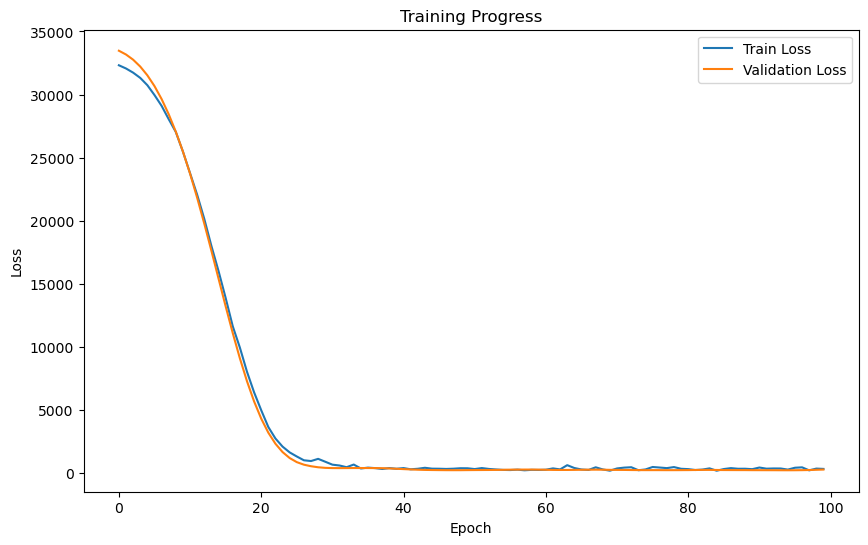

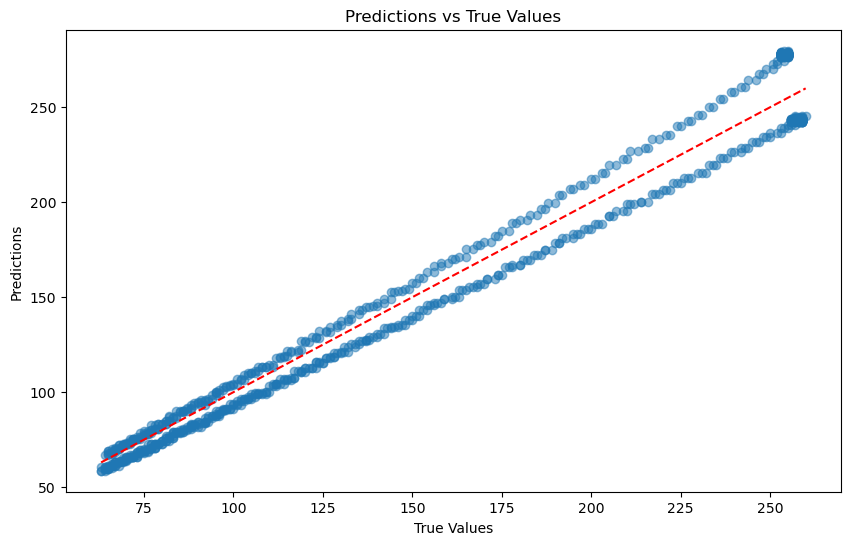

In [32]:
def train_eval_model(dataset, num_epochs=100, batch_size=8, hidden_channels=64):
    
    sample = dataset[0]
    print(f"Single sample target shape: {sample.y.shape}")
    
    # Split data
    indices = list(range(len(dataset)))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)
    
    print(train_idx, test_idx, val_idx)
    
    # Create data loaders with correct batch sizes
    train_loader = DataLoader([dataset[i] for i in train_idx], batch_size=batch_size)
    val_loader = DataLoader([dataset[i] for i in val_idx], batch_size=batch_size//4)
    test_loader = DataLoader([dataset[i] for i in test_idx], batch_size=batch_size//4)
    
    first_batch = next(iter(train_loader))
    print(f"Batch target shape: {first_batch.y.shape}")
    
    # Initialize model
    model = MetapathGNN(dataset[0], hidden_channels=hidden_channels)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses, val_losses = [], []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass with shape checking
            out = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
            
            # Debug prints for first batch of first epoch
            if epoch == 0 and batch_idx == 0:
                print(f"Batch size = {batch_size}")
                print(f"Output shape: {out.shape}")
                print(f"Target shape: {batch.y.shape}")
            
            actual_batch_size = out.size(0)
            print(f"Actual batch size: {actual_batch_size}")
            target = batch.y.view(actual_batch_size, -1)
            # Compute loss
            loss = F.mse_loss(out, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
                actual_batch_size = out.size(0)
                print(f"Actual batch size: {actual_batch_size}")
                target = batch.y.view(actual_batch_size, -1)
                val_loss += F.mse_loss(out, target).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
    
    # Test evaluation
    model.eval()
    test_loss = 0
    predictions = []
    true_values = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
            # target = batch.y.view(batch_size//4, -1) 
            actual_batch_size = out.size(0)
            print(f"Actual batch size: {actual_batch_size}")
            target = batch.y.view(actual_batch_size, -1)
            test_loss += F.mse_loss(out, target).item()
            predictions.extend(out.cpu().numpy())
            true_values.extend(batch.y.cpu().numpy())
    
    avg_test_loss = test_loss / len(test_loader)
    print(f'\nTest Loss: {avg_test_loss:.4f}')
    
    return model, predictions, true_values, train_losses, val_losses


# Train the model and visualize results
model, predictions, true_values, train_losses, val_losses = train_eval_model(dataset)

# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.show()

# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.show()
